# III. HÁZI FELADAT

Ezt a feladatsort Python nyelven kell megoldani. A kimeneti adatok ábrázolásához minden esetben használjuk a jupyter notebookot! Az ábrák legyenek áttekinthetőek, és szerepeljen rajtuk tengelyfelirat!

Az feladatok megoldásához szükség lesz az `ahkab` nevű áramkörszimulációs csomagra, és a `SchemDraw` nevű, kapcsolási rajzok készítésére szolgáló csomagra, melyek legfrissebb verziói `pip` segítségével installálhatók:

```
$ pip install git+https://github.com/ahkab/ahkab.git
$ pip install SchemDraw
```

# Passzív áramkörök numerikus vizsgálata

Lineáris, időben állandó fizikai rendszerek vizsgálatakor gyakran foglalkozunk ideális elektronikus áramkörökkel, hiszen az elméleti érdekességeken túl ezek a gyakorlatban is igen fontosak. Az alábbi feladatok passzív elektronikai alkatrészekből (ellenállás, kondenzátor és induktivitás) megépíthető áramkörök viselkedését vizsgálják, de az alkalmazott módszerek a jelfeldolgozás területén általánosan használhatók. A feladatok megoldása során az `ahkab` áramkörszimulációs csomagot használjuk, mely nagy időfelbontással számítja ki az áramkör egyes csomópontjaiban megjelenő jelalakokat (időfüggő feszültségeket). Az ilyen szimuláció közelebb áll a valódi analóg áramkörök működéséhez. A későbbiekben olyan, ún. diszkrét idejű rendszerekkel is fogalkozunk majd, melyek a digitális jelfeldolgozás modelljének tekinthetők.

A passzív elektronikai altrészek viselkedése a következő egyszerű fizikai törvényekkel írhatók le, ahol $u = u(t)$ az időfüggő feszültség, $i = i(t)$ az áram, $R$ az elleneállás, $C$ a kapacitás és $L$ az induktivitás:

* Ellenállás: $$ u = R i $$

* Kondenzátor: $$ \frac{du}{dt} = \frac{1}{C} i $$

* Induktivitás: $$ u = L \frac{di}{dt} $$

Konkrét áramkörök esetében az egyes komponensekre felírt differenciálegyenleteket a [Kirchhoff-törvények](https://hu.wikipedia.org/wiki/Kirchhoff-törvények) kapcsolják rendszerbe. Az egyenletek megoldásakor valamelyik bemeneti jelalakot (feszültség- vagy áramérték időbeli változását) előírjuk, és a rendszer erre adott válaszát, azaz egy kimeneti jelalak időfejlődését keressük.

Érdekes elméleti kérdés, hogy egy rendszer milyen választ ad egy nagyon rövid ideig tartó vizsgálóimpulzus esetében. Matematikailag az ilyen vizsgálóimpulzusokat Dirac-delta függvénnyel írjuk le, és ismert, hogy egy lineáris, időinvariáns rendszer válaszfüggvénye tetszőleges gerjesztés esetében meghatározható az **impulzusválasz** (más néven Green-függvény) és a gerjesztés konvolúciójaként:

$$
u_\mathrm{out}(t) = \int_{-\infty}^{t} u_\mathrm{in}(\tau) g(t-\tau) d\tau,
$$

ahol az, hogy az integrálás $t$-ig tart a rendszer kauzalitását fejezi ki.

Lineáris időinvariáns rendszereket érdemes Fourier-kifejtésben vizsgálni. Ilyekor a rendszer szinuszos bemenő gerjesztésekre adott válaszát keressük, ami a tranziens viselkedés lecsengése után a linearitás miatt azonos frekvenciájú, szintén szinuszos jelalak lesz. Egy rendszer **átviteli függvénye** megadja, hogy egy $f$ frekvenciájú szinuszos gerjesztés esetében a rendszer mekkora csillagpítást, illetve fázistolást okoz. Ismert, hogy Fourier-térben a konvolúció művelete a gerjesztés és az impulzusválasz Fourier-transzformáltjának szorzataként írható fel, és ebből az is következik, hogy az átviteli függvény az impulzusválasz Fourier-transzformáltja.

A feladatok során passzív áramköri elemekből összállított analóg szűrőket vizsgálunk, melyek az ún. Butterworth-topológiát követik. Az interneten elérhetők olyan eszközök, melyekkel különböző átviteli karakterisztikájú passzív vagy aktív szűrők tervezhetők, ld. pl.:    
    
* https://rf-tools.com/lc-filter/
* https://www.analog.com/designtools/en/filterwizard/

Az alábbi cellák olyan függvényeket definiálnak, melyek segítségével az ahkab programcsomag részletes ismerete nélkül is kiszámíthajuk néhány áramkör bemenő jelre adott válaszfüggvényét.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import ahkab
from ahkab import new_ac, run
from ahkab.circuit import Circuit
from ahkab import circuit, printing, time_functions

import SchemDraw as schem
import SchemDraw.elements as elem

%pylab inline
from scipy import signal
import numpy as np
from sympy import DiracDelta
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
def run_transient(circuit, fun, tstart=0, tstop=1e-2, tstep=1e-5):
    gnd = circuit.get_ground_node()
    circuit.add_vsource("V_in", n1="n_in", n2=gnd, dc_value=5, ac_value=1, function=fun)
    t = ahkab.new_tran(tstart=tstart, tstop=tstop, tstep=tstep, x0=None)
    r = ahkab.run(circuit, an_list=[t])
   
    time = r['tran']['T']
    source = fun(r['tran']['T'])
    response = r['tran']['Vn_out']
   
    circuit.remove_elem("V_in")
   
    return time, source, response

## Egyszerű aluláteresztő RC-kör

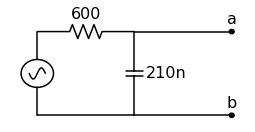

In [3]:
def rc_lowpass():
    c = circuit.Circuit(title="RC-tag")
    
    c.add_resistor("R1", n1="n_in", n2="n_out", value=600)
    c.add_capacitor("C1", n1="n_out", n2=c.gnd, value=210e-9)
    
    return c

def draw_rc_lowpass():
    d = schem.Drawing()
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R = d.add(elem.RES, d='right', label='600')
    C = d.add(elem.CAP, d='down', botlabel='210n')
    d.add(elem.LINE, to=V_in.start)
    d.add(elem.LINE, d='right', xy=R.end)
    d.add(elem.DOT, label='a')
    d.add(elem.LINE, d='right', xy=C.end)
    d.add(elem.DOT, label='b')
    d.draw()
    
draw_rc_lowpass()

## 4-ed rendű Butterworth-féle aluláteresztő szűrő

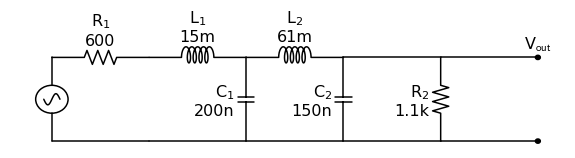

In [4]:
def butterworth_lowpass():
    c = circuit.Circuit(title="4-ed rendű Butterworth-féle aluláteresztő szűrő")
    
    c.add_resistor("R1", n1="n_in", n2="n2", value=600)
    c.add_inductor("L1", n1="n2", n2="n3", value=15e-3)
    c.add_capacitor("C1", n1="n3", n2=c.gnd, value=200e-9)
    c.add_inductor("L2", n1="n3", n2="n_out", value=61e-3)
    c.add_capacitor("C2", n1="n_out", n2=c.gnd, value=150e-9)
    c.add_resistor("R2", n1="n_out", n2=c.gnd, value=1.1e3)
    
    return c

def draw_butterworth_lowpass():
    d = schem.Drawing()
    
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R1 = d.add(elem.RES, d='right', label='$R_1$\n600')
    L1 = d.add(elem.INDUCTOR2, d='right', label='$L_1$\n15m')
    C1 = d.add(elem.CAP, d='down', label='$C_1$\n200n')
    L2 = d.add(elem.INDUCTOR2, d='right', xy=C1.start, label='$L_2$\n61m')
    C2 = d.add(elem.CAP, d='down', label='$C_2$\n150n')
    d.add(elem.LINE, d='right', xy=C2.start)
    R2 = d.add(elem.RES, d='down', label='$R_2$\n1.1k')
    for i in range(4): d.add(elem.LINE, d='left')
    d.add(elem.LINE, d='right', xy=R2.start)
    d.add(elem.DOT, label='$V_\mathrm{out}$')
    d.add(elem.LINE, d='right', xy=R2.end)
    d.add(elem.DOT)
    
    d.draw()
    
draw_butterworth_lowpass()

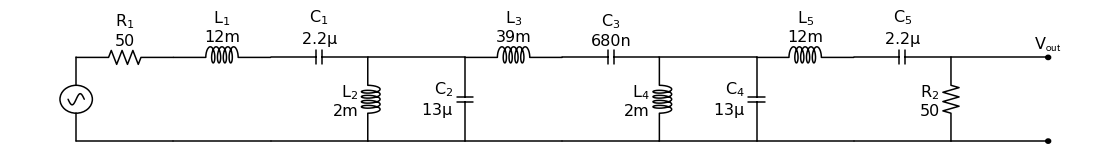

In [5]:
def butterworth_bandpass():
    c = Circuit('Butterworth-féle 1kHz-es sáváteresztő szűrő')
    
    c.add_resistor('R1', 'n_in', 'n2', 50.)
    c.add_inductor('L1', 'n2', 'n3', 12e-3)
    c.add_capacitor('C1', 'n3', 'n4', 2.2e-6)
    c.add_inductor('L2', 'n4', c.gnd, 2e-3)
    c.add_capacitor('C2', 'n4', c.gnd, 13e-6)
    c.add_inductor('L3', 'n4', 'n5', 39e-3)
    c.add_capacitor('C3', 'n5', 'n6', 680e-9)
    c.add_inductor('L4', 'n6', c.gnd, 2e-3)
    c.add_capacitor('C4', 'n6', c.gnd, 13e-6)
    c.add_capacitor('C5', 'n7', 'n_out', 2.2e-6)
    c.add_inductor('L5', 'n6', 'n7', 12e-3)
    c.add_resistor('R2', 'n_out', c.gnd, 50.)
    
    return c

def draw_butterworth_bandpass():
    d = schem.Drawing()
    
    V_in = d.add(elem.SOURCE_SIN, d='up')
    R1 = d.add(elem.RES, d='right', label='$R_1$\n50')
    L1 = d.add(elem.INDUCTOR2, d='right', label='$L_1$\n12m')
    C1 = d.add(elem.CAP, d='right', label='$C_1$\n2.2$\mu$')
    L2 = d.add(elem.INDUCTOR2, d='down', label='$L_2$\n2m')
    d.add(elem.LINE, d='right', xy=L2.start)
    C2 = d.add(elem.CAP, d='down', label='$C_2$\n13$\mu$')
    L3 = d.add(elem.INDUCTOR2, d='right', xy=C2.start, label='$L_3$\n39m')
    C3 = d.add(elem.CAP, d='right', label='$C_3$\n680n')
    L4 = d.add(elem.INDUCTOR2, d='down', label='$L_4$\n2m')
    d.add(elem.LINE, d='right', xy=L4.start)
    C4 = d.add(elem.CAP, d='down', label='$C_4$\n13$\mu$')
    L5 = d.add(elem.INDUCTOR2, d='right', xy=C4.start, label='$L_5$\n12m')
    C5 = d.add(elem.CAP, d='right', label='$C_5$\n2.2$\mu$')
    R2 = d.add(elem.RES, d='down', label='$R_2$\n50')
    for i in range(9): d.add(elem.LINE, d='left')
    d.add(elem.LINE, d='right', xy=R2.start)
    d.add(elem.DOT, label='$V_\mathrm{out}$')
    d.add(elem.LINE, d='right', xy=R2.end)
    d.add(elem.DOT)
    
    d.draw()
    
draw_butterworth_bandpass()

# Feladatok

## 1. feladat - Mérőjelek szimulációja

Analóg áramkörök kísérleti, szimulált és analitikus vizsgálatakor gyakran alkalmazunk ún. mérőjeleket. Írjunk függvényeket, melyek megvalósítják

* a tetszőleges frekvenciájú, amplitúdójú és fázisú szinuszos mérőjelet.
* a tetszőleges periódusidejű és amplitúdójú négyszögjelet.
* az egységimpulzust.
* az egységugrást.

Ábrázoljuk a mérőjeleket grafikonon. Interpoláció segítségével mintavételezzük a megvalósított mérőjeleket állandó időbeli felbontással. Milyen mintavételezési frekvencia szükséges egy $f$ frekvenciájú szinuszhullám mintavételezéséhez?

In [6]:
# mérőjeleket megvalósítő függvények

#Sinus-os függvények

def szin(A,freq,gam,t): # A-val beállítom az amplitúdót, freq-el adom meg a frekvenciát
    omega = 2*np.pi*freq           
    sig = A* np.sin(omega*t+gam)
    
    return sig

def Nszög(A,f,t): # x mintavételezés tartománya
    # Plot the square wave signal
    sig = A * signal.square(2 * np.pi * f * t)
    
    return sig


def Eimp(n,k,t):
    Eimp1 = signal.unit_impulse(n,k) # n-db, k-helyen, k nak 'mid'-et adva pont középre rakja
    return Eimp1
t = linspace(-1, 1, 10001)

def hs(t, t0 = 0):
    return 1 * (t >= t0)


  

modSzin = szin(1,100,0,np.linspace(0,10e-3,500))#Amplitudo,Frekvencia,Fázis, Tartomány

modNszög_t = linspace(-1, 1, 10000)
modNszög_sig = modNszög = Nszög(1,8,linspace(-1, 1, 10000))   #utolsó argumentum adja frekvenciát,Amplitudó


Eimp_sign = Eimp(30,1,linspace(0,10e-3,1000))    #Lépéshossz,Egységimp helye


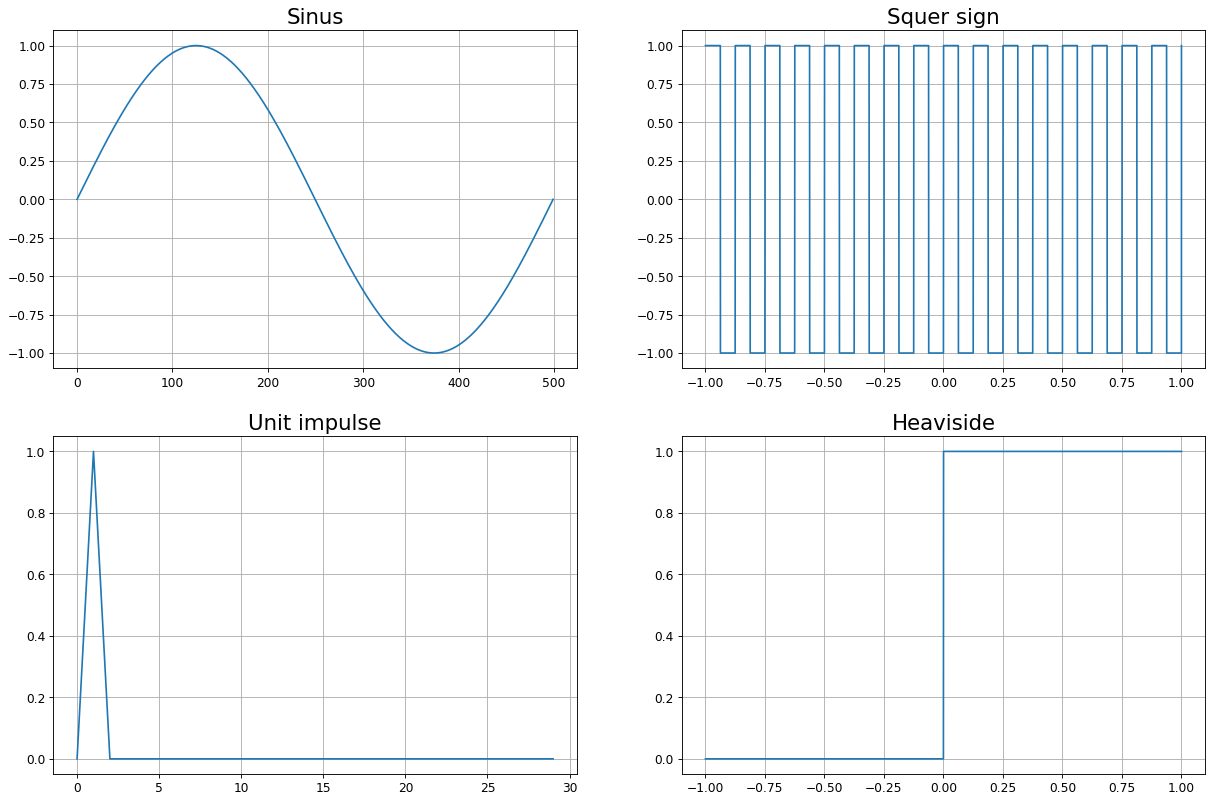

In [7]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Sinus")
plot(modSzin) # Sinus 
grid(True)

subplot(2, 2, 2)
title("Squer sign")
plot(modNszög_t,modNszög_sig) # Négyszögjel
grid(True)

subplot(2, 2, 3)
title("Unit impulse")
plot(Eimp_sign) #Egységimpulzus
grid(True)

subplot(2, 2, 4)
title("Heaviside")
plot(t,hs(t))
grid(True)

## 2. feladat - Mérőjelekre adott válaszok analízise

Szimuláljuk a mérőjelek hatását a fenti függvényekben definiált áramkörökre:

* Butterworth-féle aluláteresztő szűrő
* Butterworth-féle 1kHz-es sáváteresztő szűrő

Egységurás és impulzus esetén ügyeljünk arra, hogy a szimulált áramkörök viselkedését kiértékelő algoritmus csak folytonos, szakadással nem rendelkező függvények esetében működik, így célszerű a mérőjeleket az `interp1d` osztály segítségével "folytonossá" alakítani.

A paraméterezendő függvényeket legegyszerűbben ún. lambda kifejezésként adhatjuk át a tranziens viselkedést kiszámító `run_transient` függvénynek.

Az alábbi példa az RC-tag válaszfüggvényét mutatja 1kHz-es szinuszos gerjesztés esetén.

Text(0, 0.5, 'V')

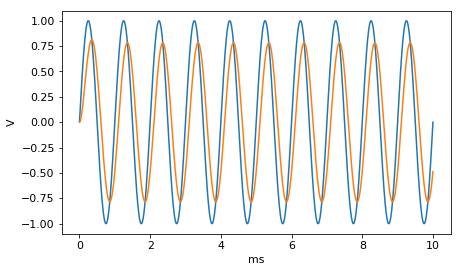

In [8]:
#Példa feladat
c = rc_lowpass()
t, s, r = run_transient(c, lambda t: np.sin(1000 * 2 * np.pi * t), tstart=0, tstop=10e-3)

plt.plot(t * 1e3, s)
plt.plot(t * 1e3, r)
plt.xlabel("ms")
plt.ylabel("V")

## Ábrázolások saját szinusszal

In [9]:
c_0 = rc_lowpass()
c_1 = butterworth_bandpass()
c_2 = butterworth_lowpass()

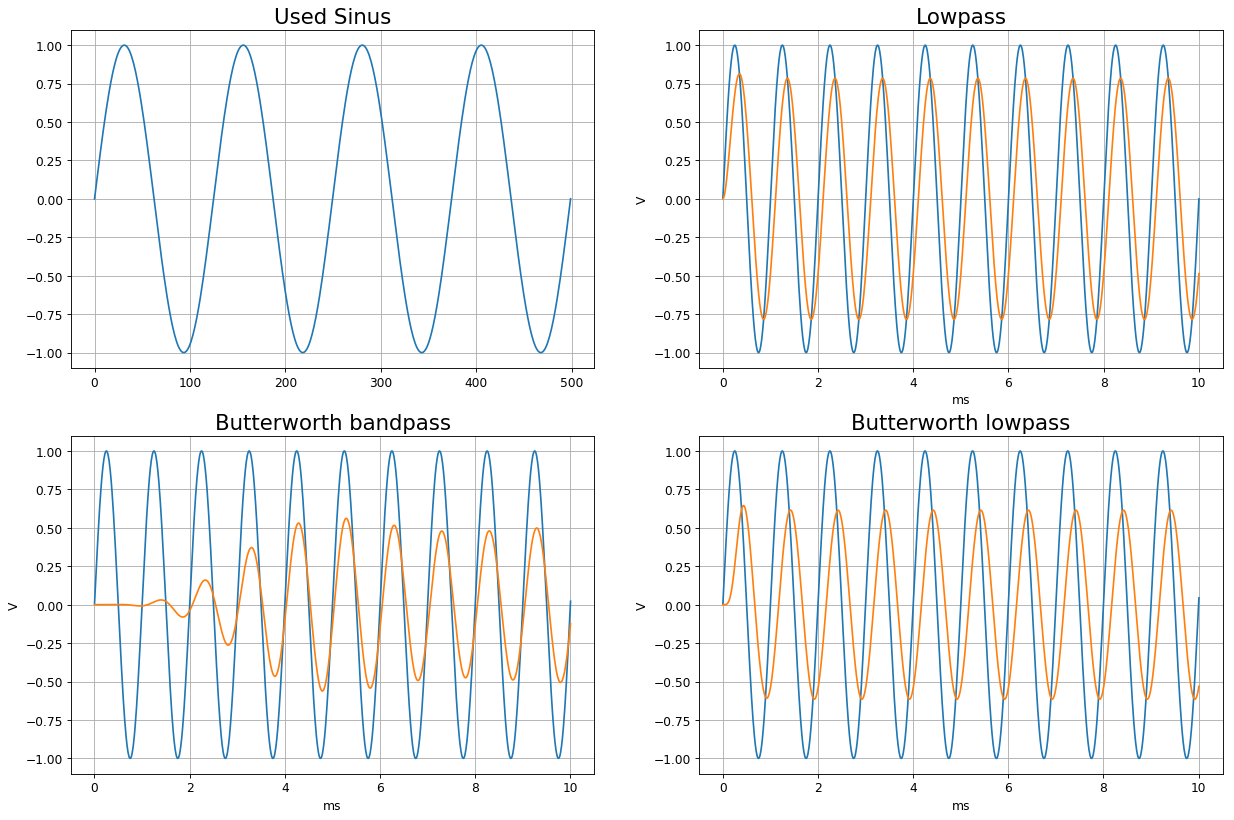

In [10]:
t = linspace(0, 2, 500)
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Used Sinus")
plot(szin(1,1000,0,t)) 
grid(True)

subplot(2, 2, 2)
title("Lowpass")
t_sin_0, s_sin_0, r_sin_0 = run_transient(c_0, lambda t: szin(1,1000,0,t), tstart=0, tstop=10e-3)
plot(t_sin_0 * 1e3, s_sin_0)
plot(t_sin_0 * 1e3, r_sin_0)
xlabel("ms")
ylabel("V") 
grid(True)

subplot(2, 2, 3)
title("Butterworth bandpass")
t_sin_1, s_sin_1, r_sin_1 = run_transient(c_1, lambda t: szin(1,1000,0,t), tstart=0, tstop=10e-3)
plot(t_sin_1 * 1e3, s_sin_1)
plot(t_sin_1 * 1e3, r_sin_1)
xlabel("ms")
ylabel("V")
grid(True)

subplot(2, 2, 4)
title("Butterworth lowpass")
t_sin_2, s_sin_2, r_sin_2 = run_transient(c_2, lambda t: szin(1,1000,0,t), tstart=0, tstop=10e-3)
plot(t_sin_2 * 1e3, s_sin_2)
plot(t_sin_2 * 1e3, r_sin_2)
xlabel("ms")
ylabel("V")
grid(True)

## Ábrázolások saját Négyszögjellel

In [11]:
t = linspace(-1, 1, 10001)
sqi = interp1d(t, Nszög(1,2,t), kind = 'linear')

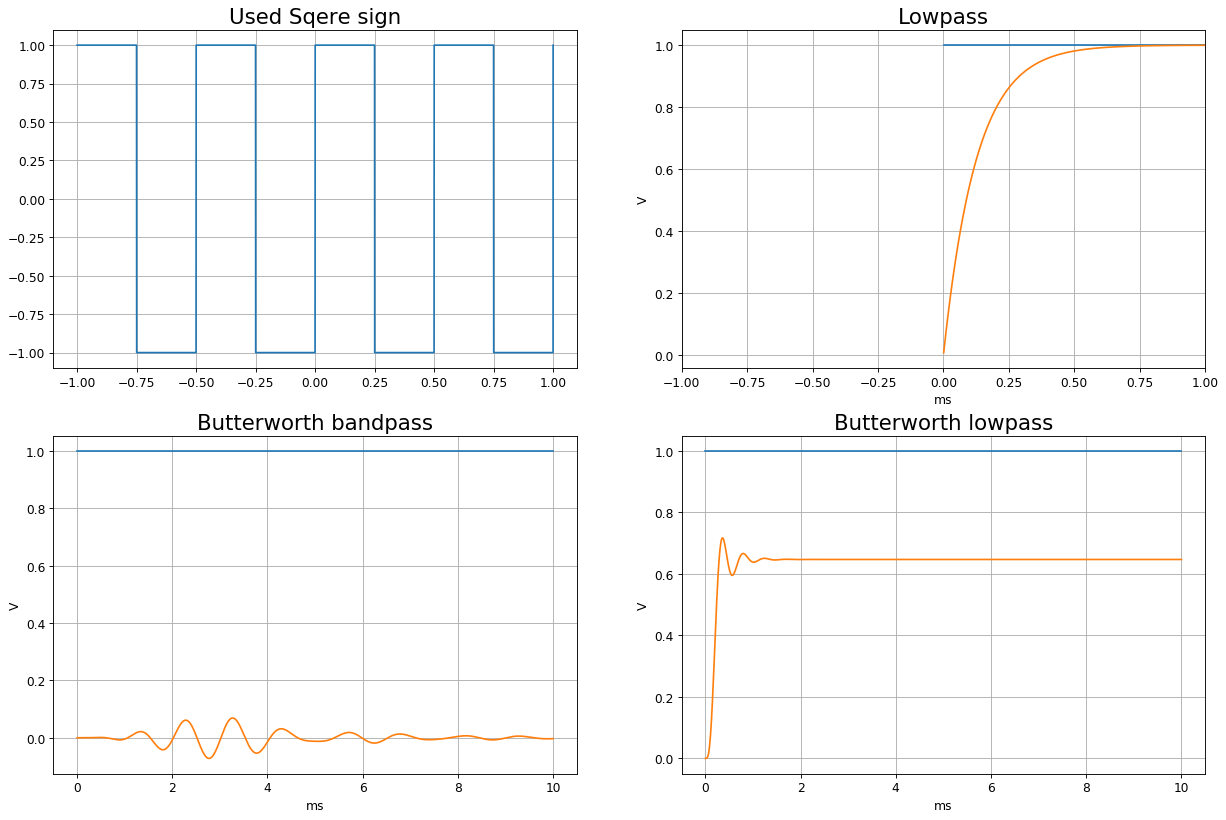

In [12]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Used Sqere sign")
plot(t,sqi(t))
grid(True)

subplot(2, 2, 2)
title("Lowpass")
t_negy_0, s_negy_0, r_negy_0 = run_transient(c_0, sqi, tstart=0, tstop=10e-3)
plot(t_negy_0 * 1e3, s_negy_0)
plot(t_negy_0 * 1e3, r_negy_0)
xlabel("ms")
ylabel("V")
xlim(-1,1)
grid(True)

subplot(2, 2, 3)
title("Butterworth bandpass")
t_negy_1, s_negy_1, r_negy_1 = run_transient(c_1,sqi, tstart=0, tstop=10e-3)
plot(t_negy_1 * 1e3, s_negy_1)
plot(t_negy_1 * 1e3, r_negy_1)
xlabel("ms")
ylabel("V")
grid(True)

subplot(2, 2, 4)
title("Butterworth lowpass")
t_negy_2, s_negy_2, r_negy_2 = run_transient(c_2,sqi, tstart=0, tstop=10e-3)
plot(t_negy_2 * 1e3, s_negy_2)
plot(t_negy_2 * 1e3, r_negy_2)
xlabel("ms")
ylabel("V")
grid(True)

## Ábrák saját egységimpulzussal

In [13]:
#Újra definiálom, hogy könnyebben kezelhessem az interpolációt
def kd(t, t0 = 0):
    return 1 * (t == t0)

t = linspace(-1, 1, 10001)

kdi = interp1d(t, kd(t), kind = 'linear')

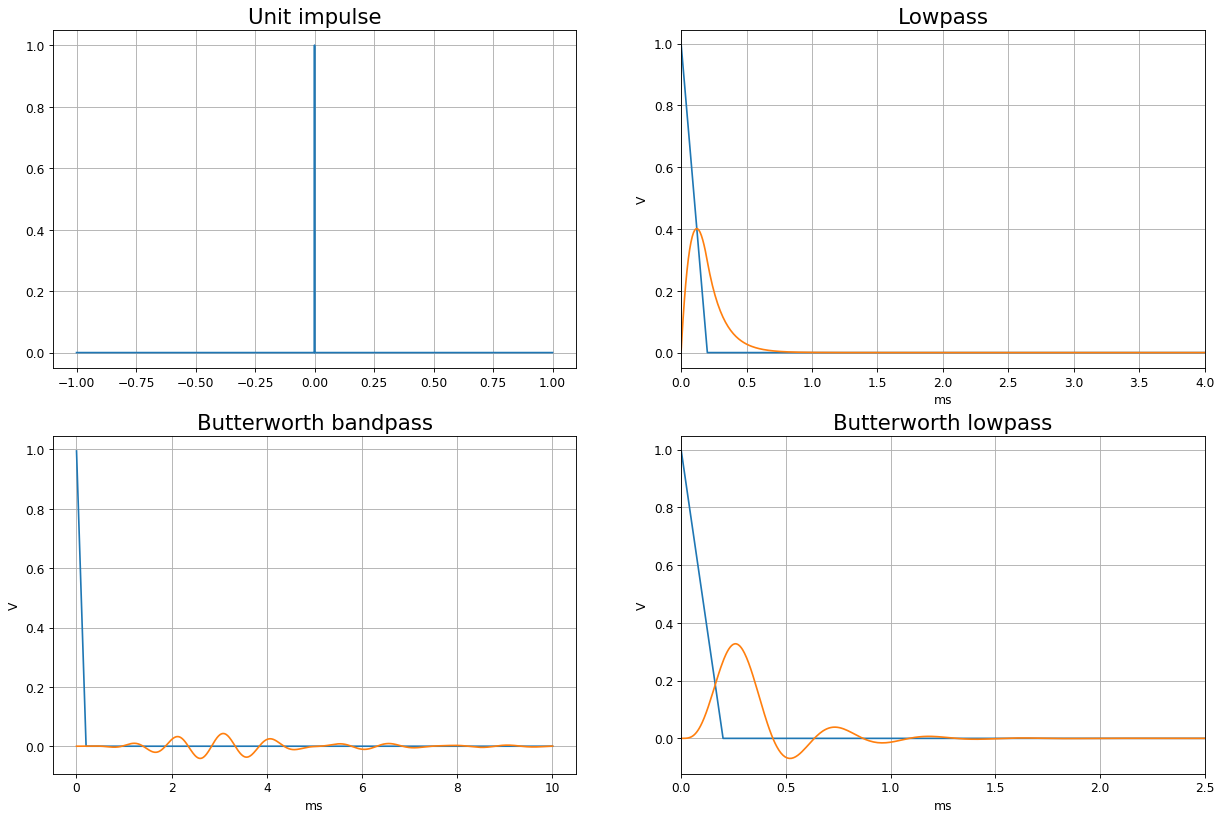

In [14]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Unit impulse")
plot(t, kdi(t))
grid(True)

subplot(2, 2, 2)
title("Lowpass")
t_egy0, s_egy0, r_egy0 = run_transient(c_0, kdi, tstart=0, tstop=10e-3)
plot(t_egy0 * 1e3, s_egy0)
plot(t_egy0 * 1e3, r_egy0)
xlabel("ms")
ylabel("V")
xlim(0,4)
grid(True)

subplot(2, 2, 3)
title("Butterworth bandpass")
t_egy1, s_egy1, r_egy1 = run_transient(c_1, kdi, tstart=0, tstop=10e-3)
plot(t_egy1 * 1e3, s_egy1)
plot(t_egy1 * 1e3, r_egy1)
xlabel("ms")
ylabel("V")
grid(True)

subplot(2, 2, 4)
title("Butterworth lowpass")
t_egy2, s_egy2, r_egy2 = run_transient(c_2, kdi, tstart=0, tstop=10e-3)
plot(t_egy2 * 1e3, s_egy2)
plot(t_egy2 * 1e3, r_egy2)
xlabel("ms")
ylabel("V")
xlim(0,2.5)
grid(True)

### Ábrák saját lépcsőfüggvénnyel

In [15]:
# Újra definiálom, hogy könnyebben kezelhessem az interpolációt
def hs(t, t0 = 0):
    return 1 * (t >= t0)

t = linspace(-1, 1, 10001)
hsi = interp1d(t, hs(t), kind = 'linear')

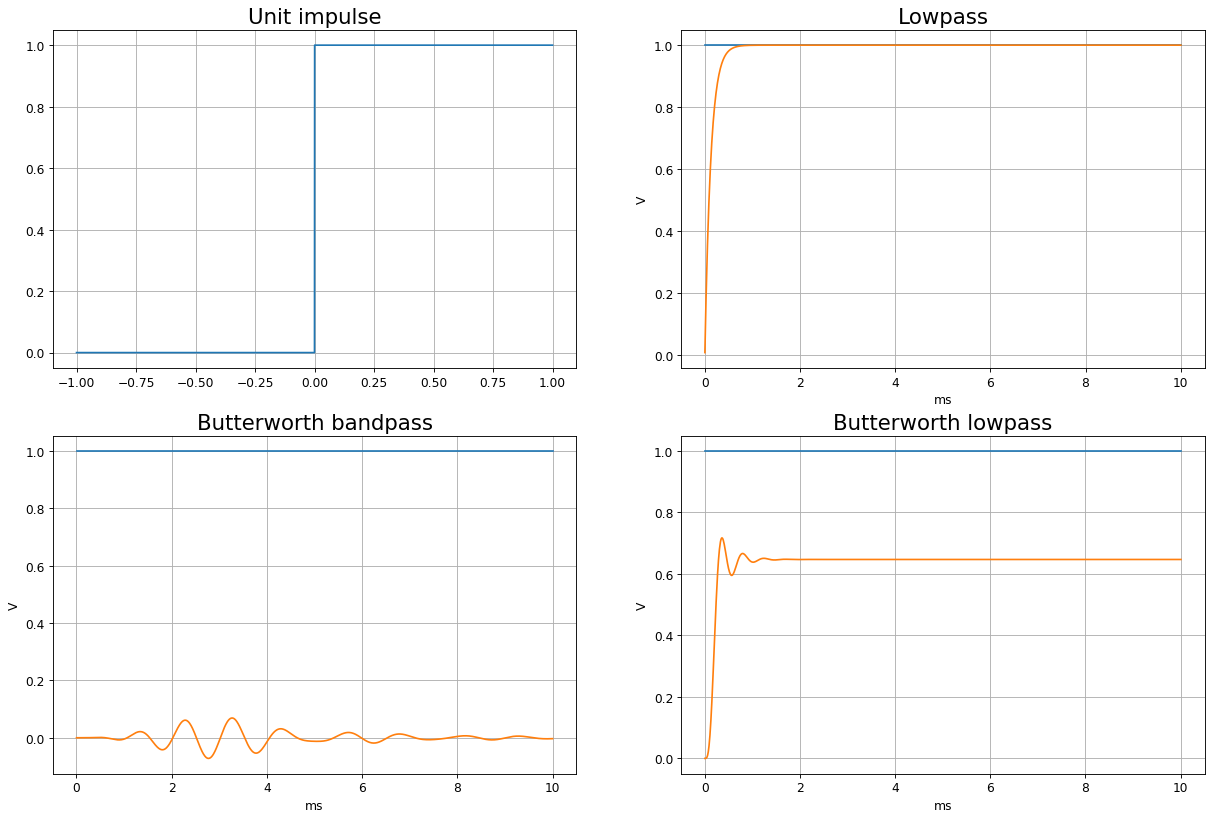

In [16]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Unit impulse")
plot(t, hsi(t))
grid(True)


subplot(2, 2, 2)
title("Lowpass")
t_lepcso0, s_lepcso0, r_lepcso0 = run_transient(c_0, hsi, tstart=0, tstop=10e-3)
plot(t_lepcso0 * 1e3, s_lepcso0)
plot(t_lepcso0 * 1e3, r_lepcso0)
xlabel("ms")
ylabel("V")
grid(True)

subplot(2, 2, 3)
title("Butterworth bandpass")
t_lepcso1, s_lepcso1, r_lepcso1 = run_transient(c_1, hsi, tstart=0, tstop=10e-3)
plot(t_lepcso1 * 1e3, s_lepcso1)
plot(t_lepcso1 * 1e3, r_lepcso1)
xlabel("ms")
ylabel("V")
grid(True)

subplot(2, 2, 4)
title("Butterworth lowpass")
t_lepcso2, s_lepcso2, r_lepcso2 = run_transient(c_2, hsi, tstart=0, tstop=10e-3)
plot(t_lepcso2 * 1e3, s_lepcso2)
plot(t_lepcso2 * 1e3, r_lepcso2)
xlabel("ms")
ylabel("V")
grid(True)

## 3. feladat - Átviteli függvény meghatározása

Szimuláljuk a rendszer kimenetét különböző fkrevenciájú szinuszos bemenőjelek esetén. Határozzuk meg a kimenet amplitúdóját és fáziseltolódását a frekvencia függvényében. Ügyeljünk arra, hogy a kimeneti jel amplitúdóját a tranziens szakasz eltűnése után kell megmérni. Ábrázoljuk az átviteli függvényt.

In [91]:
# Átviteli függvény meghatározása
t = np.linspace(0, 55, 10001)

t_sin_1, s_sin_1, r_sin_1 = run_transient(c_1, lambda t: szin(1,600,0,t), tstart=0, tstop=5.5e-2)

In [92]:
# Itt kinéztem a tranziens szakasz utáni indexet (3000) és utána néztem min, max értéket
maxi_index = [i for i, j in enumerate(r_sin_1[3000:]) if j == max(r_sin_1[3000:])][0]
min_index = [i for i, j in enumerate(r_sin_1[3000:]) if j == min(r_sin_1[3000:])][0]

# Itt számolom tranziens szakasz után, ahol jel és válasz egyenlő 0-val és ezeknek kapom vissza a ind, val-ját
jel_null = min(enumerate(s_sin_1[3150:3250]), key=lambda x: abs(x[1]-0))
valasz_null = min(enumerate(r_sin_1[3150:3250]), key=lambda x: abs(x[1]-0))

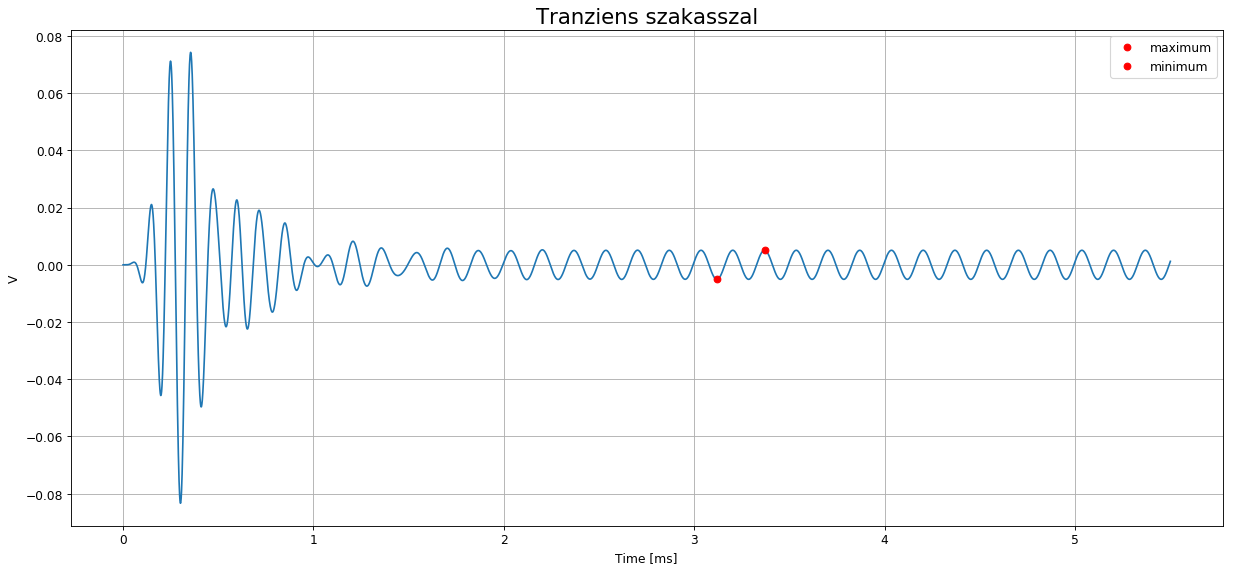

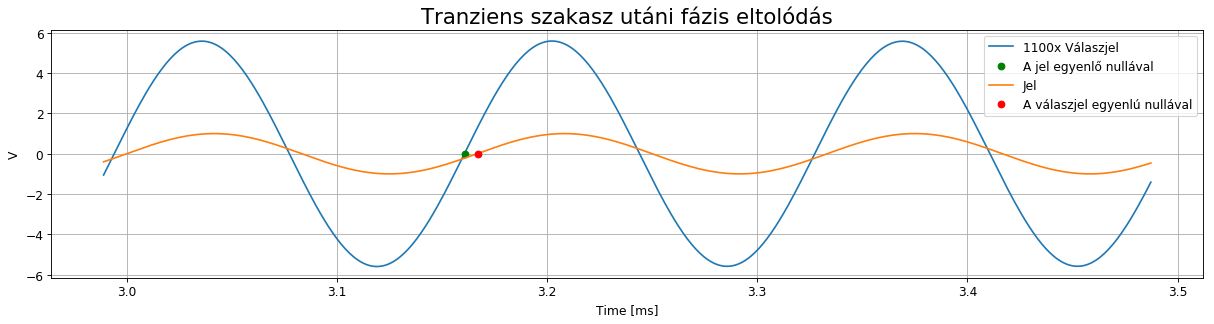

In [93]:
#### Átviteli függvény ábrázolása
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plot(t_sin_1 * 1e2, r_sin_1)

# Átviteli függvény ábrázolása

plot(t_sin_1[3382] * 1e2,r_sin_1[3382],'ro',label='maximum')
plot(t_sin_1[3131] * 1e2,r_sin_1[3131],'ro',label='minimum')
title("Tranziens szakasszal")
xlabel("Time [ms]")
ylabel("V")
legend()
grid(True)

figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')  
plot(t_sin_1[3000:3500] * 1e2, 1100*r_sin_1[3000:3500], label="1100x Válaszjel")
plot(t_sin_1[3150+valasz_null[0]] * 1e2,r_sin_1[3150+valasz_null[0]],'o',color = 'g' ,label='A jel egyenlő nullával')
plot(t_sin_1[3000:3500] * 1e2, s_sin_1[3000:3500], label="Jel")
plot(t_sin_1[3150+jel_null[0]] * 1e2,s_sin_1[3150+jel_null[0]],'o',color = 'r',label='A válaszjel egyenlú nullával')
title("Tranziens szakasz utáni fázis eltolódás")
xlabel("Time [ms]")
ylabel("V")
legend()
grid(True)

In [20]:
print("Amplitudó: " + str(abs(r_sin_1[3000+maxi_index])+abs(r_sin_1[3000+min_index])) + " V")
print("Eltolódása: " + str(abs(valasz_null[0]-jel_null[0])) + " ms")

Amplitudó: 0.010169023156969513 V
Eltolódása: 6 ms


In [21]:
tranz_end_ind = 3000
amplitude = []
phase = []
frequency = []
for i in range(0,900,5):
    t_szin, s_szin, r_szin = run_transient(c, lambda t:szin(t, 1, 600+i, 0), tstart=0, tstop=5e-2)
    frequency.append(600+i)
    #tranz_end_ind = 3000
    # max, min érték
    amplitude_maximum_index = tranz_end_ind + [i for i, j in enumerate(r_szin[3000:]) if j == max(r_szin[3000:])][0]
    amplitude_minimum_index = tranz_end_ind + [i for i, j in enumerate(r_szin[3000:]) if j == min(r_szin[3000:])][0]
    amplitude.append(abs(r_szin[amplitude_maximum_index])+abs(r_szin[amplitude_minimum_index]))
    # a jel és válasz itt egyenlő nullával
    phase_null_signal = min(enumerate(s_szin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))
    phase_null_response = min(enumerate(r_szin[amplitude_minimum_index:amplitude_minimum_index+100]), key=lambda x: abs(x[1]-0))
    phase.append(abs(phase_null_response[0]-phase_null_signal[0]))
frequency_str = [str(x) for x in frequency]

Text(0, 0.5, 'V')

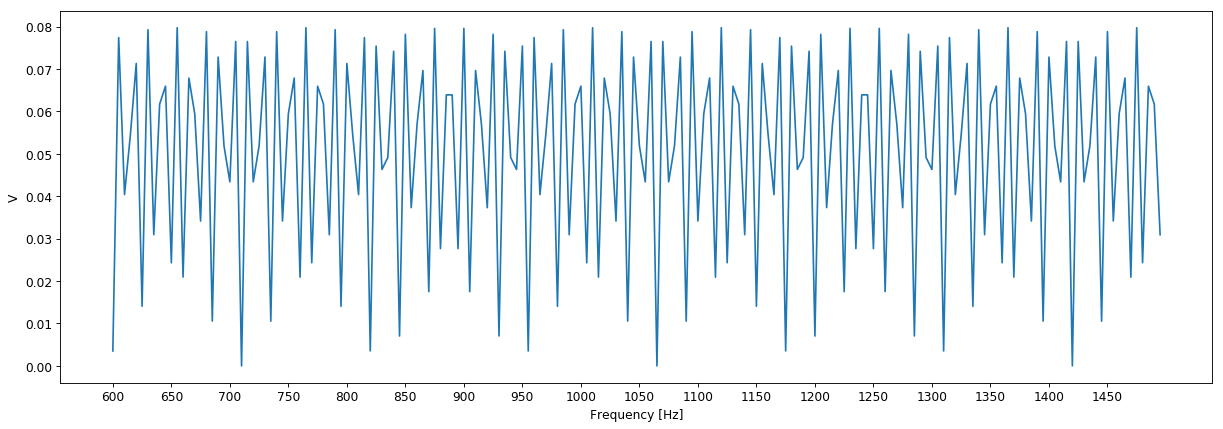

In [22]:
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plot(amplitude)
xticks(range(0, len(frequency), 10), frequency_str[::10])
xlabel('Frequency [Hz]')
ylabel("V")

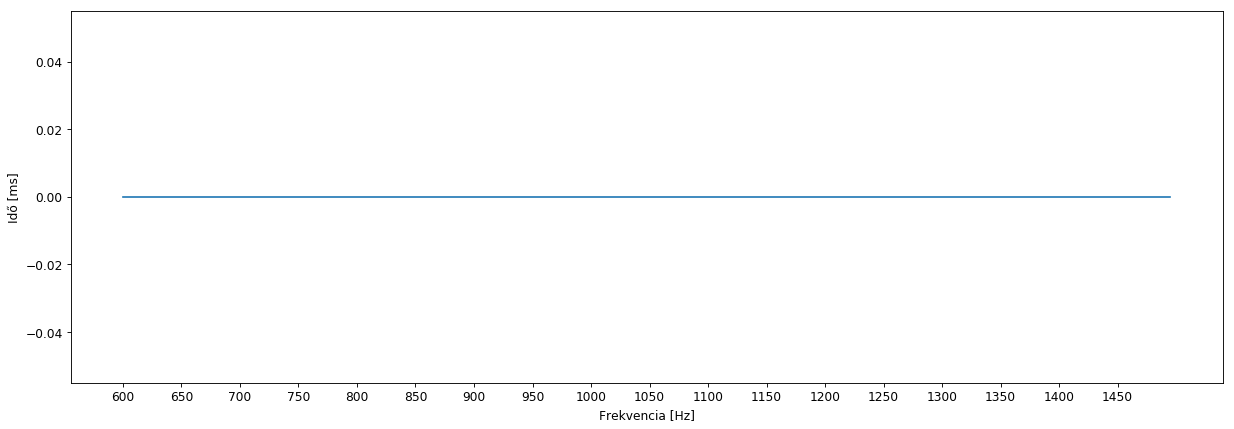

In [27]:
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
xticks(range(0, len(frequency), 10), frequency_str[::10])
ylabel("Idő [ms]")
xlabel('Frekvencia [Hz]')
plot(phase)

## 4. feladat - Az impulzusválasz tulajdonságainak vizsgálata

Szimuláljuk a fent használt sáváteresztő szűrő impulzusra adott válaszát. Mintavételezzük a válaszfüggvényt egyenletes időlépéssel, majd határozzuk meg a Fourier-transzformáltát. Hogyan viszonyul az impulzusválasz Fourier-transzformáltja az előző feladatban meghatározott átviteli függvényhez?

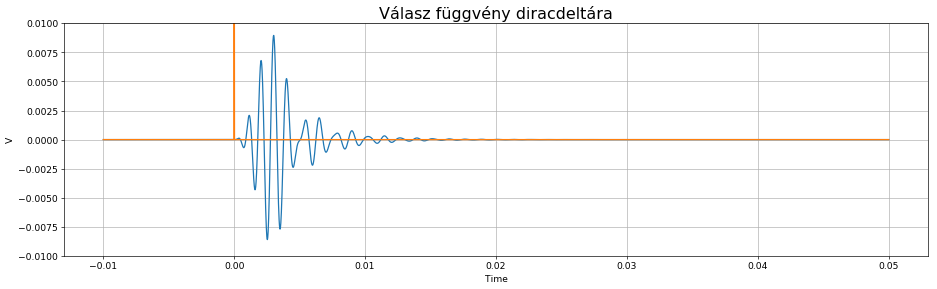

In [140]:
# Sáváteresztő szűrő impulzusválasza
figure(num=None, figsize=(16, 5), dpi=60, facecolor='w', edgecolor='k')

t = np.linspace(-1,1,100001)
mero_egysegimp_interp = interp1d(t,kd(t), kind = 'linear')
t_imp1, s_imp1, r_imp1 = run_transient(c_1, mero_egysegimp_interp, tstart=-10e-3, tstop=5e-2)
title("Válasz függvény diracdeltára")
xlabel('Time')
ylabel('V')
plot(t_imp1,r_imp1)
plot(t_imp1,s_imp1)
ylim(-0.01,0.01)
grid(True)

Interpoláljuk az impulzusválaszt egyenletes időfelbontású rácsra, majd határozzuk meg a Fourier-transzformáltját. Hasonlítsuk ezt össze a 3. feladatban meghatározott átviteli függvénnyel.

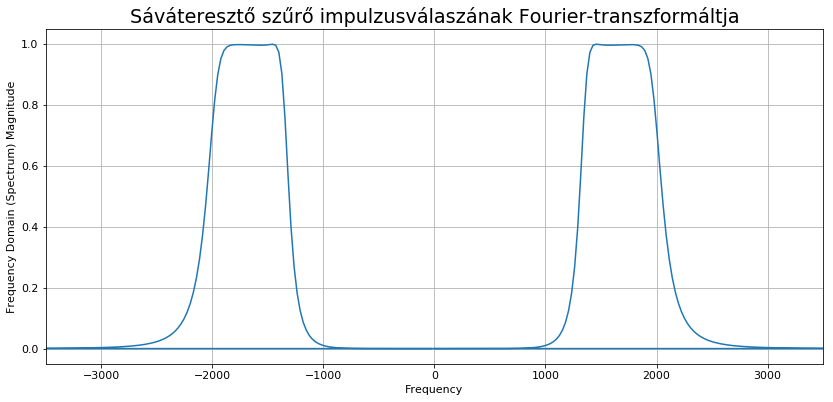

In [138]:
# Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja
from numpy.fft import *
Fjel6=fft(r_imp1)
freq6 = fftfreq(len(t_imp1),t_imp1[1]-t_imp1[0])
figure(figsize=(12, 6))
title("Sáváteresztő szűrő impulzusválaszának Fourier-transzformáltja")
xlabel('Frequency')
ylabel('Frequency Domain (Spectrum) Magnitude')
plot(freq6,abs(Fjel6))
xlim(-3500,3500)
grid(True)

(500, 1500)

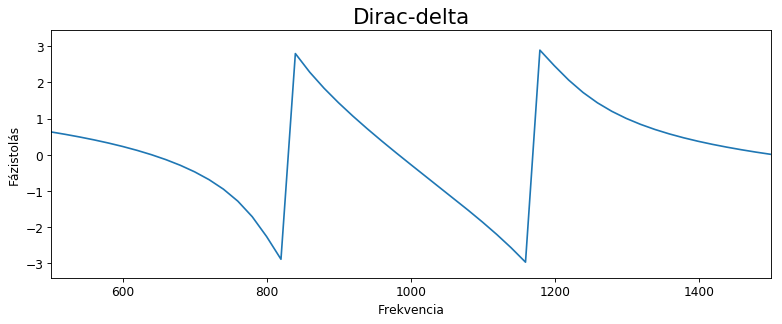

In [111]:
r_imp_interp = interp1d(t_imp1, r_imp1, kind = 'linear')
s_imp_interp = interp1d(t_imp1, s_imp1, kind = 'linear')

tt = np.linspace(0,max(t_imp1),1024)
fs = np.fft.rfft(s_imp_interp(tt))
fr = np.fft.rfft(r_imp_interp(tt))
freq = np.fft.rfftfreq(1024, tt[1] - tt[0])

r_imp_interp2 = interp1d(t_imp2, r_imp2, kind = 'linear')
s_imp_interp2 = interp1d(t_imp2, s_imp2, kind = 'linear')

tt2 = np.linspace(0,max(t_imp2),1024)
fs2 = np.fft.rfft(s_imp_interp2(tt2))
fr2 = np.fft.rfft(r_imp_interp2(tt2))
freq2 = np.fft.rfftfreq(1024, tt2[1] - tt2[0])

figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
title("Dirac-delta")
xlabel('Frekvencia')
ylabel('Fázistolás')
plot(freq, arctan2(fr.imag, fr.real))
xlim(500,1500)

Határozzuk meg az *aluláteresztő szűrő* impulzusválaszát, majd interpoláljuk időben egyenletes rácsra. Számoljuk ki a korábban már használt négyszögjel vagy más jelalak értékeit ugyanezen rácson. A `numpy.convolve` függvény segítségével számítsuk ki az impulzusválasz és a jelalak konvolúcióját. Hasonlítsuk ezt össze a 2. feladatban használt jelalakra kapott válasszal.

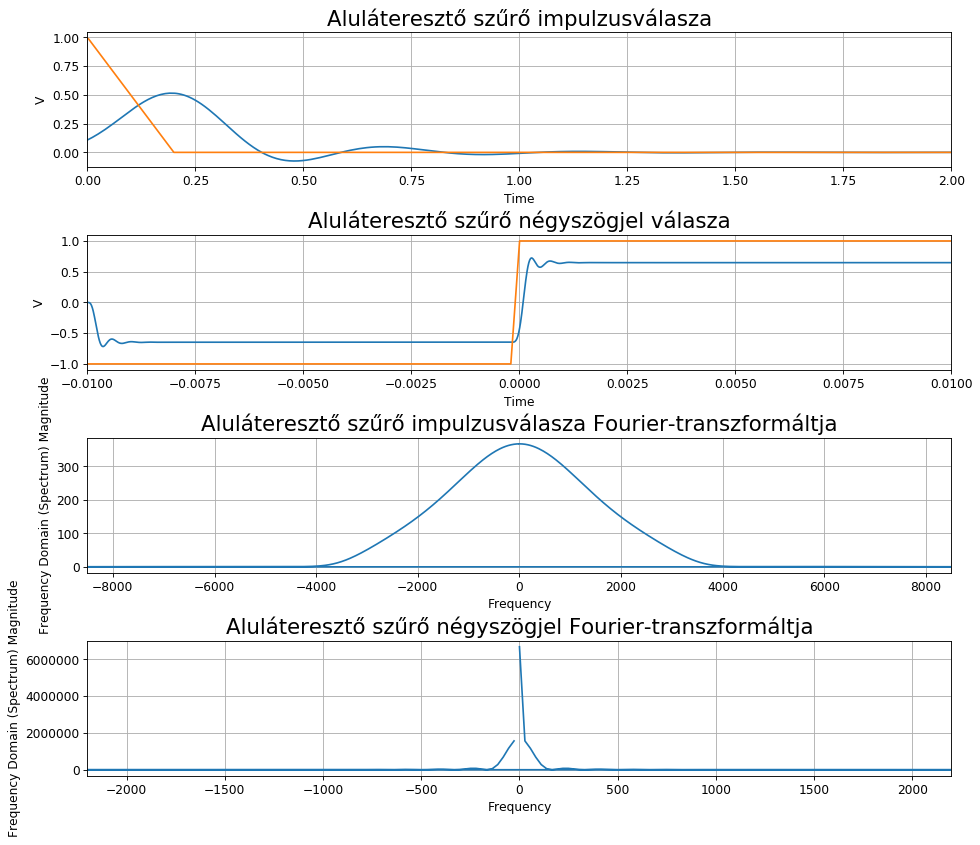

In [137]:
# Aluláteresztő szűrő impulzusválasza
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


subplot(4, 1, 1)
t = np.linspace(-1,1,100001)
t_imp2, s_imp2, r_imp2 = run_transient(c_2, mero_egysegimp_interp, tstart=-10e-3, tstop=5e-2)
title("Aluláteresztő szűrő impulzusválasza")
xlabel('Time')
ylabel('V')
plot(t_imp2* 1e3,r_imp2)
plot(t_imp2* 1e3,s_imp2)
#ylim(0,0.1)
xlim(0,2)
grid(True)

subplot(4, 1, 2)
t_sqi3, s_sqi3, r_sqi3 = run_transient(c_2, sqi, tstart=-10e-3, tstop=5e-2)
title("Aluláteresztő szűrő négyszögjel válasza")
xlabel('Time')
ylabel('V')
plot(t_sqi3,r_sqi3)
plot(t_sqi3,s_sqi3)
#ylim(0,0.1)
xlim(-0.01,0.01)
grid(True)

subplot(4, 1, 3)
Fjel7=fft(r_imp2)
freq7 = fftfreq(len(t_imp2),t_imp2[1]-t_imp2[0])
title("Aluláteresztő szűrő impulzusválasza Fourier-transzformáltja")
xlabel('Frequency')
ylabel('Frequency Domain (Spectrum) Magnitude')
plot(freq7,abs(Fjel7)**2)
xlim(-8500,8500)
grid(True)

subplot(4, 1, 4)
Fjel8=fft(r_sqi3)
freq8 = fftfreq(len(t_sqi3),t_sqi3[1]-t_sqi3[0])
title("Aluláteresztő szűrő négyszögjel Fourier-transzformáltja")
xlabel('Frequency')
ylabel('Frequency Domain (Spectrum) Magnitude')
plot(freq8,abs(Fjel8)**2)
xlim(-2200,2200)
grid(True)


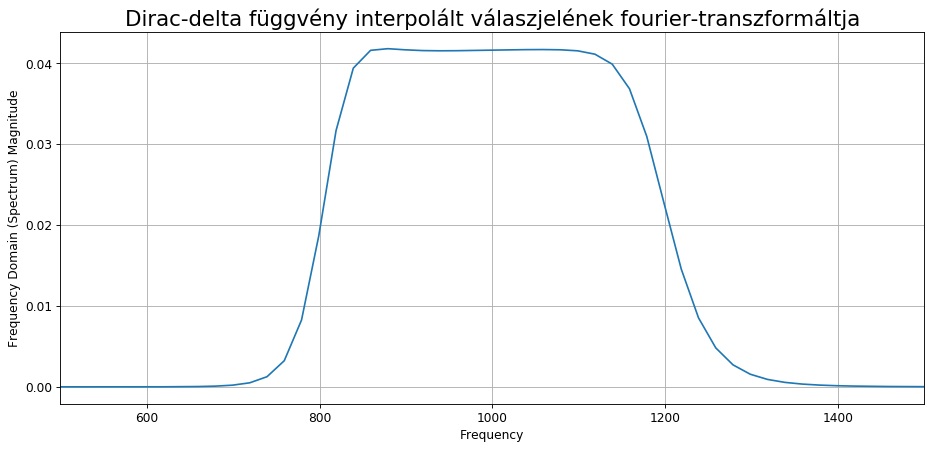

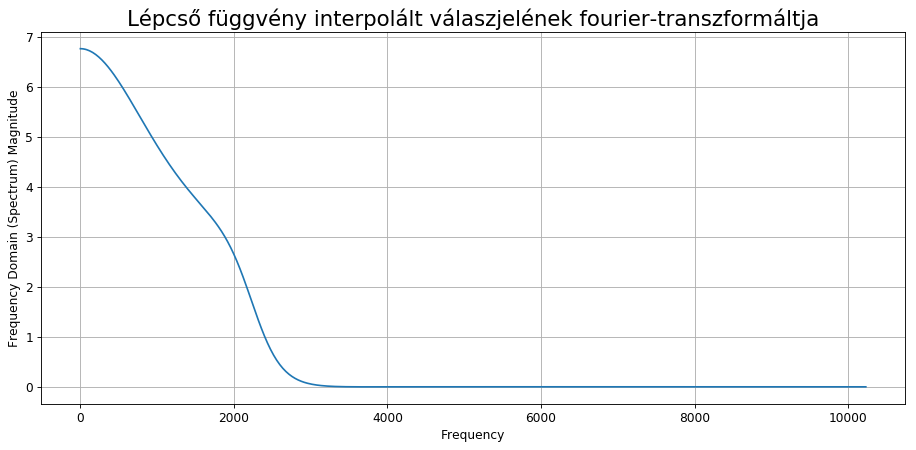

In [136]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k') 
title("Dirac-delta függvény interpolált válaszjelének fourier-transzformáltja")
xlabel('Frequency')
ylabel('Frequency Domain (Spectrum) Magnitude')
xlim(500,1500)
plot(freq, abs(fr)**2)
grid(True)

figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k') 
title("Lépcső függvény interpolált válaszjelének fourier-transzformáltja")
xlabel('Frequency')
ylabel('Frequency Domain (Spectrum) Magnitude')
plot(freq2, abs(fr2)**2)
grid(True)

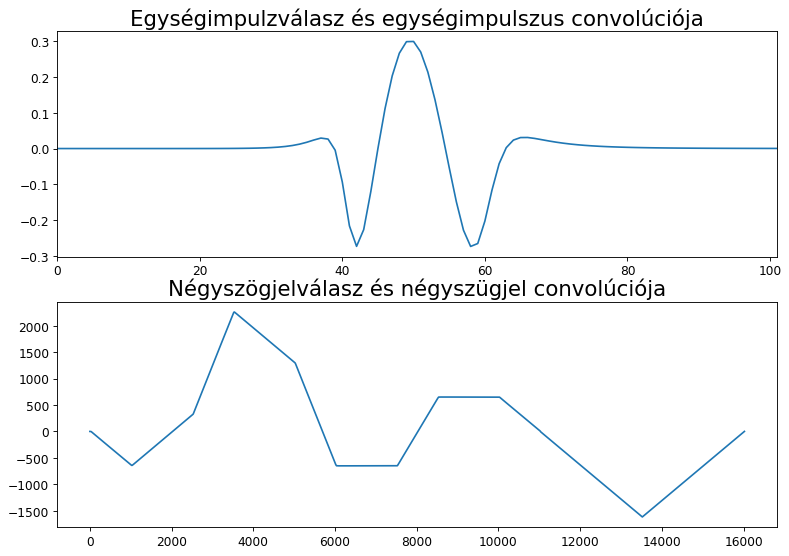

In [135]:
t = linspace(0, 1, 10000)
con_impr_imp = np.convolve(fr, kdi(t),'full')
con_sqir_sqi = np.convolve(r_sqi3,sqi(t),'full')

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
subplot(2, 1, 1)
title('Egységimpulzválasz és egységimpulszus convolúciója')
plot(con_impr_imp)
xlim(0,101)
subplot(2,1,2)
title('Négyszögjelválasz és négyszügjel convolúciója')
plot(con_sqir_sqi)

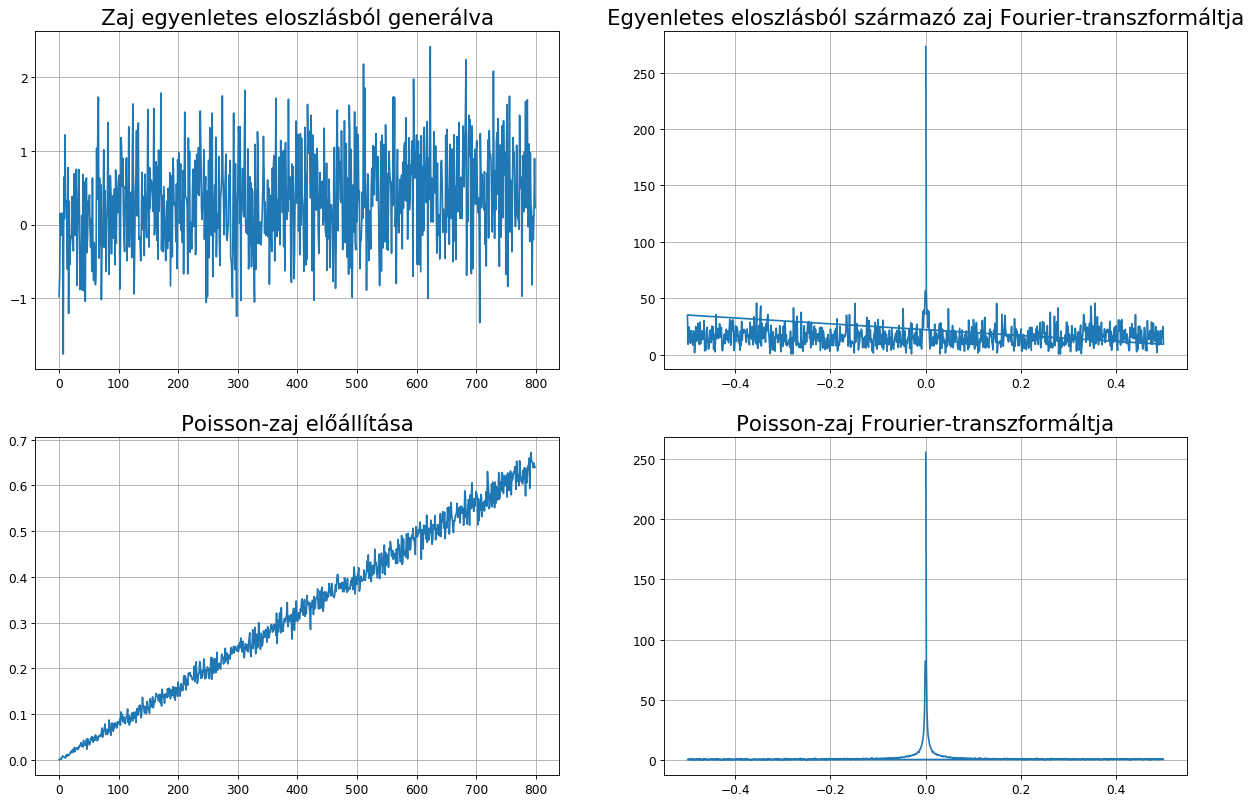

In [54]:
# Zaj egyenletes eloszlásból generálva
import random


figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(2, 2, 1)
title("Zaj egyenletes eloszlásból generálva")
Fs = 800
f = 5
x = np.arange(800)
noise = 0.0008*np.random.normal(range(0,800),800)
plot(x, noise)
grid(True)


subplot(2, 2, 2)
# Egyenletes eloszlásból származó zaj Fourier-transzformáltja
Fjel=fft(noise)
freq = fftfreq(len(x),x[1]-x[0])
title("Egyenletes eloszlásból származó zaj Fourier-transzformáltja")
plot(freq,abs(Fjel))
grid(True)

subplot(2, 2, 3)
# Poisson-zaj előállítása
noise2 = 0.0008*np.random.poisson(range(0,800),800)
title("Poisson-zaj előállítása")
plot(x, noise2)
grid(True)

subplot(2, 2, 4)
# Poisson-zaj Frourier-transzformáltja
from numpy.fft import *
Fjel2=fft(noise2)
freq2 = fftfreq(len(x),x[1]-x[0])
title("Poisson-zaj Frourier-transzformáltja")
plot(freq2,abs(Fjel2))
grid(True)

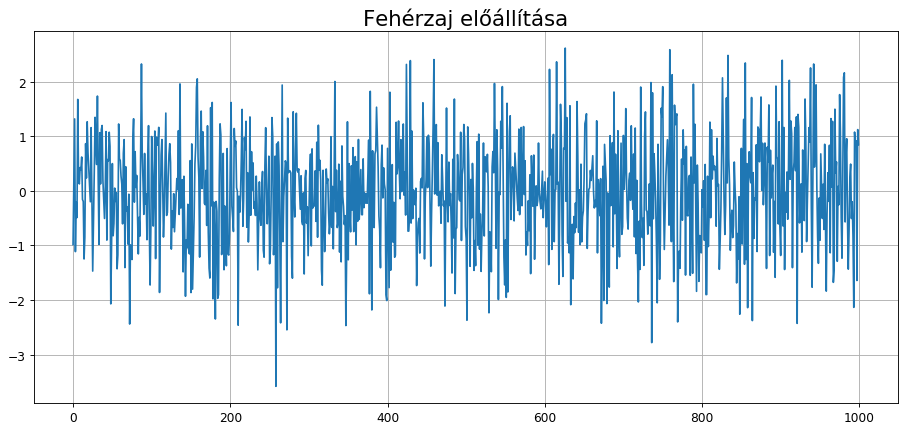

In [55]:
# Fehérzaj előállítása
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
mean = 0
std = 1 
t = 1000
samples = numpy.random.normal(mean, std, size=t)
title("Fehérzaj előállítása")
plot(samples)
grid(True)


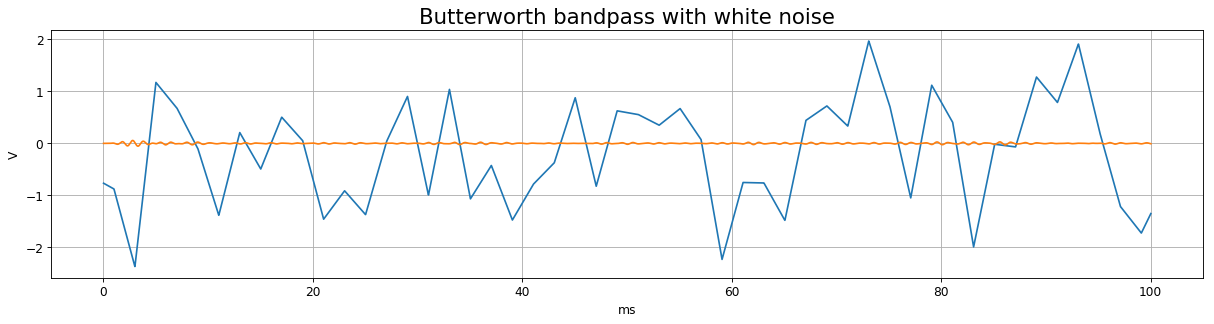

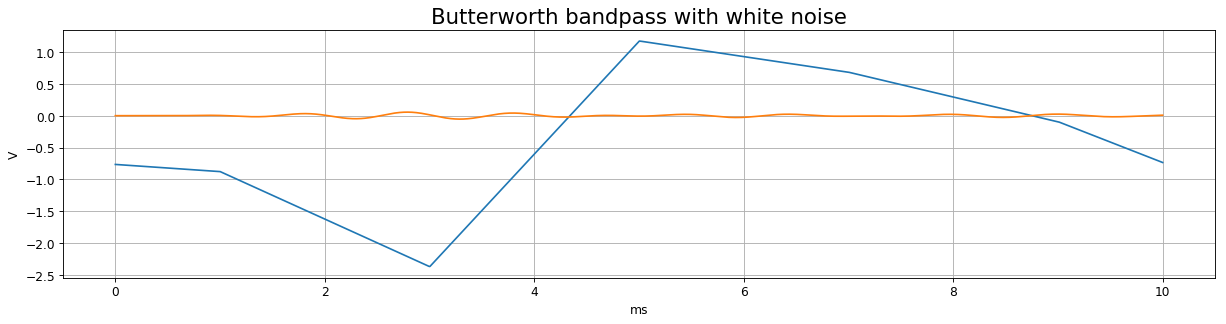

In [56]:
# Sáváteresztő szűrő fehérzajra adott válaszának meghatározása
t = linspace(-1, 1, 1000)
whiteint = interp1d(t, samples, kind = 'linear')

t_white, s_white, r_white = run_transient(c_1, whiteint, tstart=0, tstop=10e-2)
t_white2, s_white2, r_white2 = run_transient(c_1, whiteint, tstart=0, tstop=10e-3)
t_white3, s_white3, r_white3 = run_transient(c_1, whiteint, tstart=0, tstop=0.1)

figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k') 
title("Butterworth bandpass with white noise")
plot(t_white * 1e3, s_white,t_white * 1e3, r_white)
xlabel("ms")
ylabel("V")
grid(True)
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
title("Butterworth bandpass with white noise")
plot(t_white2 * 1e3, s_white2,t_white2 * 1e3, r_white2)
xlabel("ms")
ylabel("V")
grid(True)


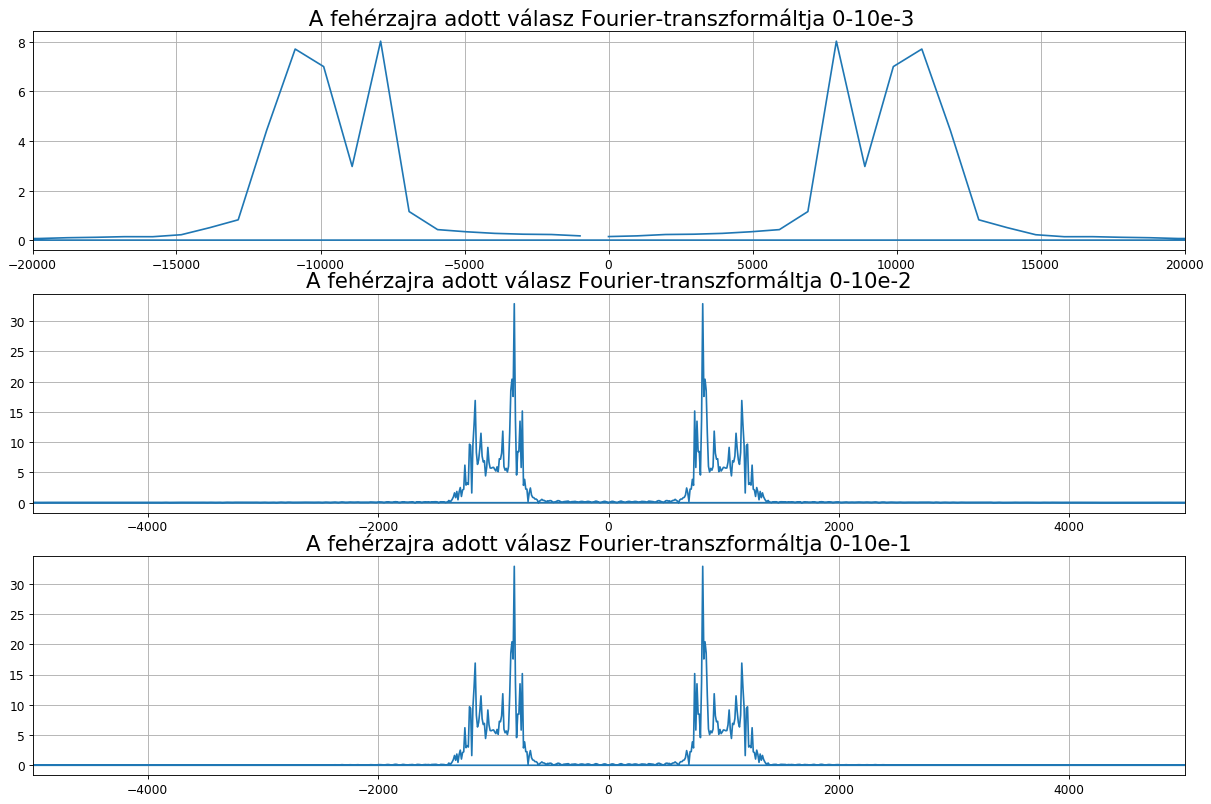

In [57]:
# Zaj egyenletes eloszlásból generálva
import random


figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='r')  
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

subplot(3, 1, 1)
title(" A fehérzajra adott válasz Fourier-transzformáltja 0-10e-3")
Fjel3=fft(r_white2)
freq3 = fftfreq(len(t_white2),t_white2[1]-t_white2[0])
plot(freq3,abs(Fjel3))
xlim(-20000,20000)
grid(True)

subplot(3, 1, 2)
title("A fehérzajra adott válasz Fourier-transzformáltja 0-10e-2")
Fjel4=fft(r_white)
freq4 = fftfreq(len(t_white),t_white[1]-t_white[0])
plot(freq4,abs(Fjel4))
xlim(-5000,5000)
grid(True)
subplot(3, 1, 3)
title("A fehérzajra adott válasz Fourier-transzformáltja 0-10e-1")
Fjel5=fft(r_white)
freq5 = fftfreq(len(t_white3),t_white3[1]-t_white3[0])
plot(freq5,abs(Fjel5))
xlim(-5000,5000)
grid(True)
